In [22]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torchvision import transforms

In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()  # Set the model to evaluation mode

Using cache found in C:\Users\natalie_molina/.cache\torch\hub\pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [27]:
def preprocess_input(image):
    image = image / 255.0  # normalizar
    return image

In [8]:
#preprocess_input(cv2.imread("vo1.jpg"))  FUNCIONA

In [30]:
def segment_clothing(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Resize
    input_image = cv2.resize(original_image, (2048, 3072))
    input_image = preprocess_input(input_image)
    #input_image = torch.tensor(input_image).permute(2, 0, 1).unsqueeze(0)  # Convert to tensor and add batch dimension
    print("pre",input_image.shape)
    # Convert to tensor, add batch dimension, and change type to float32
    input_image = torch.tensor(input_image).permute(2, 0, 1).unsqueeze(0).float() # permute es las dimensiones reorganizadas(canales, altura y ancho), unsqueeze agrega una dimension pq pytorch espera un lote
    print("post", input_image.shape)
    
    # Segmentation
    with torch.no_grad():  # Disable gradient calculations
        predictions = model(input_image)
    segmentation_mask = torch.argmax(predictions["out"][0], dim=0).numpy() 

    # Create a mask for the clothing (using class 15 for "person" in the Pascal VOC dataset)
    clothing_mask = (segmentation_mask == 15).astype(np.uint8)

    # Resize to original dimensions
    clothing_mask = cv2.resize(clothing_mask, (original_image.shape[1], original_image.shape[0]))

    # Mask to keep only the clothing
    segmented_image = cv2.bitwise_and(original_image, original_image, mask=clothing_mask)

    return original_image, segmented_image



In [31]:
original_image, segmented_image = segment_clothing("vo1.jpg")

pre (3072, 2048, 3)
post torch.Size([1, 3, 3072, 2048])


In [51]:
def extract_dominant_colors(segmented_image, num_colors=5):
    
    # Reshape  to 2D array of pixels
    pixel_values = segmented_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values) # mejor par kmeans

    # Remove background
    pixel_values = pixel_values[~np.all(pixel_values == [0, 0, 0], axis=1)] # elegir todos los pixeles que NO (~) son negros ([0,0,0])

    # K-Means clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixel_values)
    #print(kmeans.cluster_centers_)
    
    # Get the dominant colors
    dominant_colors = kmeans.cluster_centers_
    dominant_colors = np.round(dominant_colors).astype(int)

    # Create the color palette
    palette = np.zeros((100, 300, 3), dtype=np.uint8)
    for i in range(num_colors):
        palette[:, i * 60:(i + 1) * 60] = dominant_colors[i]

    # Display the color palette
    plt.figure(figsize=(5, 2))
    plt.imshow(palette)
    plt.axis('off')
    plt.title('Dominant Colors')
    plt.show()


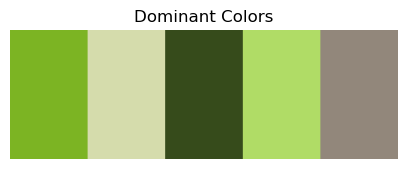

In [52]:
extract_dominant_colors(segmented_image,5)

In [33]:
def extract_dominant_colors_from_clothing(image_path, num_colors=5):
    # Segment the clothing
    original_image, segmented_image = segment_clothing(image_path)

    # Reshape the segmented image to a 2D array of pixels
    pixel_values = segmented_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Remove black pixels (background)
    pixel_values = pixel_values[~np.all(pixel_values == [0, 0, 0], axis=1)]

    # K-Means clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixel_values)

    # Get the dominant colors
    dominant_colors = kmeans.cluster_centers_
    dominant_colors = np.round(dominant_colors).astype(int)

    # Create the color palette
    palette = np.zeros((100, 300, 3), dtype=np.uint8)
    for i in range(num_colors):
        palette[:, i * 60:(i + 1) * 60] = dominant_colors[i]

    # Display the original image, segmented image, and color palette
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.title('Segmented Clothing Image')

    plt.subplot(1, 3, 3)
    plt.imshow(palette)
    plt.axis('off')
    plt.title('Dominant Colors')
    
    plt.show()

pre (3072, 2048, 3)
post torch.Size([1, 3, 3072, 2048])


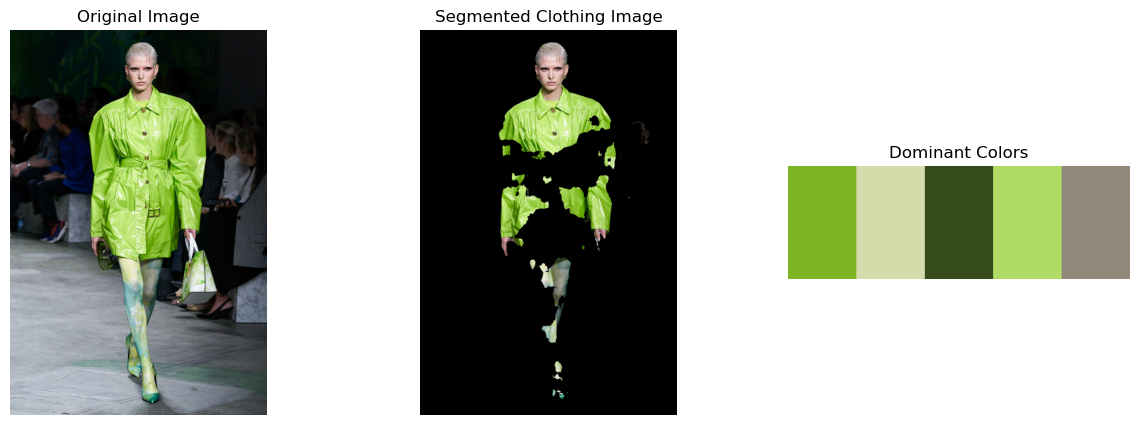

In [36]:
extract_dominant_colors_from_clothing('vo1.jpg', num_colors=5)